In [1]:
from display.display_figures import display_REstim, display_dataBuilt
from display.display_figures_by_county import display_comparison_uni_multi, display_comparison_error_uni_multi

from include.build_synth import buildData_fromRO as build
from include.build_synth import load_RO as load
from include.build_synth.Tikhonov_method import Tikhonov_spat_corr
from include.build_synth.compute_spatCorrLevels import compute_spatCorrLevels

from include.optim_tools.sliding_median import sliding_median

# For Rt estimation
from include.estim.Rt_MLE import Rt_MLE
from include.estim.Rt_Gamma import Rt_Gamma
from include.estim.Rt_Univariate import Rt_U
from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Multivariate import Rt_M

from include.comparison_tools import SNR
from include.comparison_tools import jaccard_index
from include.comparison_tools import MSE

## Building univariate synthetic infection counts

Building according to the chosen configuration and initial number of cases.
See demo_buildSyntheticData.ipynb for more detailed building synthetic data explanations.

In [8]:
configuration = 'I'  # Choice of configuration
firstCases = 100  # Choice of number of first cases on day one

# Loading realistic RTrue and OTrue
RTrue, OTrue = load.loadROconfig(configuration)

# Building synthetic data
ZDataBuilt, options = build.buildData_anyRO(RTrue, OTrue, firstCases)

# Cropping RTrue for further comparisons
RTrueCrop = RTrue[1:];

In [ ]:
# Intermediate display of built data
display_dataBuilt(ZDataBuilt, RTrue, OTrue, options=options);

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:240: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## Comparison between R estimation methods

### Signal-to-Ratio Noise (dB)

$\mathsf{SNR}:=  10 \times \log_{10}\left( \frac{\lVert  \boldsymbol{\mathsf{R}}^{\text{true}}\rVert_2^2}{\lVert \widehat{\boldsymbol{\mathsf{R}}} - \boldsymbol{\mathsf{R}}^{\text{true}} \rVert_2^2}\right)$

where $\widehat{\boldsymbol{\mathsf{R}}}$ is the estimated $\boldsymbol{\mathsf{R}}$ with a chosen method.
### Jaccard index (%)

For $\boldsymbol{\mathsf{X}}, \boldsymbol{\mathsf{Y}} \in \lbrace 0, 1\rbrace^T, \, \,  \mathsf{Jac}^{\mathsf{g}}(\boldsymbol{\mathsf{X}},\boldsymbol{\mathsf{Y}}) := \frac{\sum_{t=1}^T \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}{\sum_{t=1}^T \mathsf{X}^{\mathsf{g}}_t + \mathsf{Y}^{\mathsf{g}}_t - \sqrt{\mathsf{X}^{\mathsf{g}}_t \times \mathsf{Y}^{\mathsf{g}}_t}}$

where $\mathsf{X}^{\mathsf{g}}$ (resp. $\mathsf{Y}^{\mathsf{g}}$) is the convolution between the binary vector $\boldsymbol{\mathsf{X}}$ (resp. $\boldsymbol{\mathsf{Y}}$) and a Gaussian distribution.
(see include/comparison_tools/jaccardIndex.py for more details)

### Maximum Likelihood Estimator
* $\mathsf{R}^{\mathsf{MLE}} \in \mathrm{arg\, min}_{\mathsf{R} \in  \mathbb{R} ^ {\mathsf{T}}} -\ln \mathsf{Likelihood}(\mathsf{Z} ^ {\mathsf{denoised}},  \mathsf{R})$

In [ ]:
# Analytic computation
Rt_MLE, options_MLE = Rt_MLE(ZDataBuilt, options)

In [ ]:
# Computing SNR and Jaccard index
print('MLE Method indicators ---')
SNR_MLE = SNR.SignaltoNoiseRatio(RTrueCrop, Rt_MLE)
JaccardIndexMLE = jaccard_index.JaccardIndexREstim(RTrueCrop, Rt_MLE)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_MLE, JaccardIndexMLE))

In [ ]:
# Individual display
display_REstim(Rt_MLE, RTrue=RTrue, options=options_MLE);

### Bayesian Estimator

$$\mathsf{R}_t^\Gamma = \frac{1 + \sum_{s=t-\tau}^{t}\mathsf{Z}_s}{5 + \sum_{s=t-\tau}^{t}(\Phi\star\mathsf{Z})_s}$$


In [ ]:
# Choice of the hyperparameter
tau = 15

# Analytic computation
Rt_Gamma, options_Gamma = Rt_Gamma(ZDataBuilt, tau=tau, options=options)

In [ ]:
# Computing SNR and Jaccard index
print('Cori Method indicators ---')
SNR_Gamma = SNR.SignaltoNoiseRatio(RTrueCrop, Rt_Gamma)
JaccardIndexGamma = jaccard_index.JaccardIndexREstim(RTrueCrop, Rt_Gamma)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_Gamma, JaccardIndexGamma))

In [ ]:
# Individual display
display_REstim(Rt_Gamma, RTrue=RTrue, options=options_Gamma);

### Penalized Likelihood estimation
1. $\boldsymbol{\mathsf{Z}}^{\mathsf{denoised}} =$ `sliding_median`$(\mathsf{Z}, \alpha)$

2. $ \boldsymbol{\mathsf{R}}^{\mathsf{U}} = \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}}^{\mathsf{denoised}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$

In [ ]:
# Choice of denoising parameter alpha and regularization parameter muR
alpha = 0.1
muR = 50

# Denoising with sliding median then solving with Chambolle-Pock algorithm
Z_denoised = sliding_median(ZDataBuilt, alpha)
Rt_U, options_U = Rt_U(Z_denoised, muR=muR, options=options)


In [ ]:
# Computing SNR and Jaccard index
print('PL Method indicators ---')
SNR_U = SNR.SignaltoNoiseRatio(RTrueCrop, Rt_U)
JaccardIndexU = jaccard_index.JaccardIndexREstim(RTrueCrop, Rt_U)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_U, JaccardIndexU))

In [ ]:
# Individual display

display_REstim(Rt_U, RTrue=RTrue, options=options_U);

### Joint estimation

$$\boldsymbol{\mathsf{R}}^{\mathsf{U-O}}, \boldsymbol{\mathsf{O}}^{\mathsf{U-O}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}, \boldsymbol{\mathsf{O}} \in \mathbb{R}^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 + \lambda_\mathsf{O}^\mathsf{U} \lVert \mathsf{O}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

In [ ]:
# Choice of denoising parameter alpha and regularization parameter muR
lambdaR = 3.5
lambdaO = 0.03

# Solving with Chambolle-Pock algorithm
Rt_UO, Ot_UO, options_UO = Rt_U_O(ZDataBuilt, lambdaR=lambdaR, lambdaO=lambdaO, options=options)


In [ ]:
# Computing SNR and Jaccard index
print('J Method indicators ---')
SNR_UO = SNR.SignaltoNoiseRatio(RTrueCrop, Rt_UO)
JaccardIndexUO = jaccard_index.JaccardIndexREstim(RTrueCrop, Rt_UO)
print("SNR = %.3f dB, associated Jaccard index = %.3f %%" % (SNR_UO, JaccardIndexUO))

In [ ]:
# Individual display
display_REstim(Rt_UO, RTrue=RTrue, options=options_UO);

### Display comparison

In [ ]:
# Gather all methods
REstimations = {'MLE': Rt_MLE, 'Gamma': Rt_Gamma, 'U': Rt_U, 'U-O': Rt_UO}
optionsAll = {'MLE': options_MLE, 'Gamma': options_Gamma, 'U': options_U, 'U-O': options_UO}

# Display comparison between methods
display_REstim(REstimations, optionsAll, RTrue=RTrue, comparison=True);

## Multivariate/univariate performances comparison

In [3]:
# Choice of connectivity structure and spatial correlation level (configMulti) for multivariate synthetic infection counts
connectStruct = 'Line'

# Adding inter-county correlations to initial realistic univariate R crafted on each county.
R_by_county, O_by_county, firstCasesExample, B_matrix = load.loadROconfigMulti(connectStruct, '0')

# Visualization of inter-county correlation levels
delta_I, delta_II, delta_III, delta_IV = compute_spatCorrLevels(R_by_county, B_matrix, fileSuffix=connectStruct)
deltaList = {'0': 0,
             'I': delta_I,
             'II': delta_II,
             'III': delta_III,
             'IV': delta_IV}

# Build synthetic infection counts based on RTrue, OTrue and chosen firstCases for ONE CONFIGURATION
configMulti = 'I'
R_spat_corr = Tikhonov_spat_corr(R_by_county, B_matrix, delta=deltaList[configMulti])

firstCasesMulti = firstCasesExample  # can be modified if needed
ZDataBuilt, options = build.buildDataMulti_anyRO(R_spat_corr, O_by_county, firstCasesMulti, B_matrix)

In [4]:
R_uni, options_U = Rt_U(ZDataBuilt, options=options)

Computing Univariate estimator ...
Done in 3.4578 seconds ---


In [5]:
R_multi, options_M = Rt_M(ZDataBuilt, options=options)

Computing Multivariate estimator ...
iter 100000.000000 	 crit=105.115747 

Done in 39.0887 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:212: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:274: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


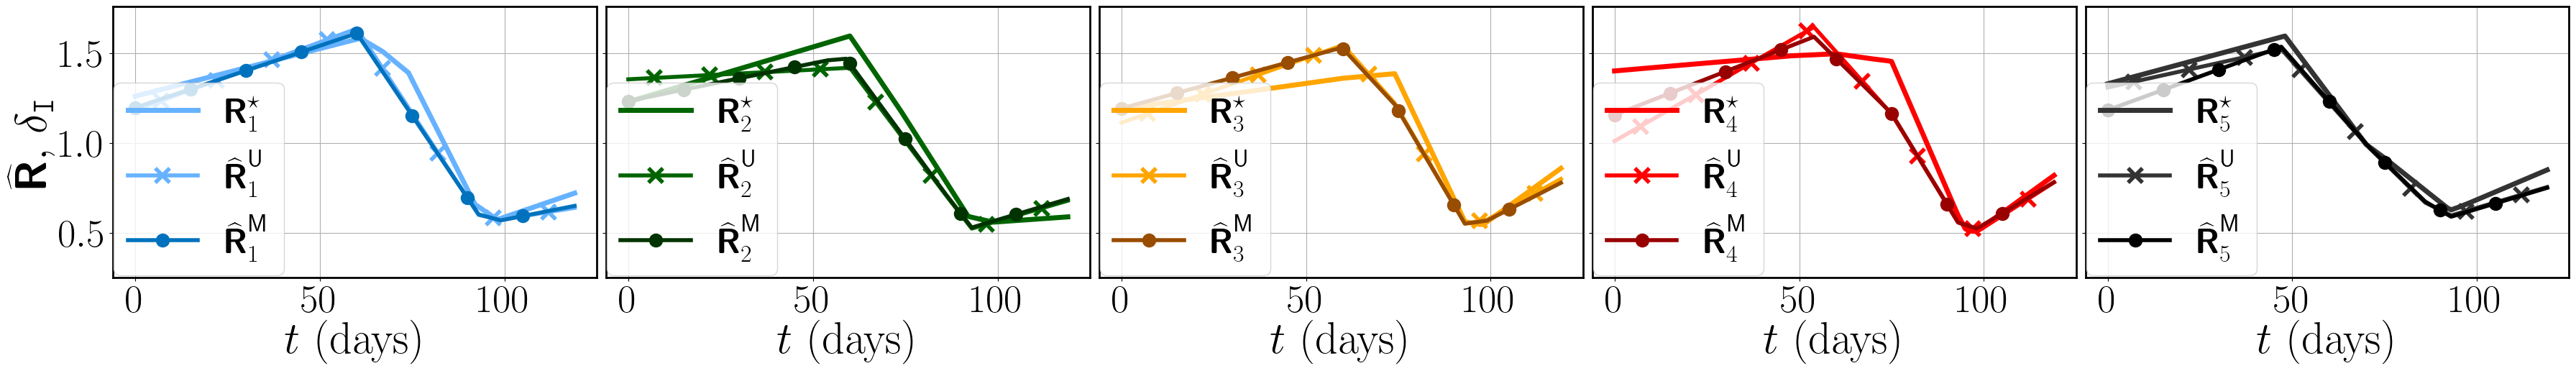

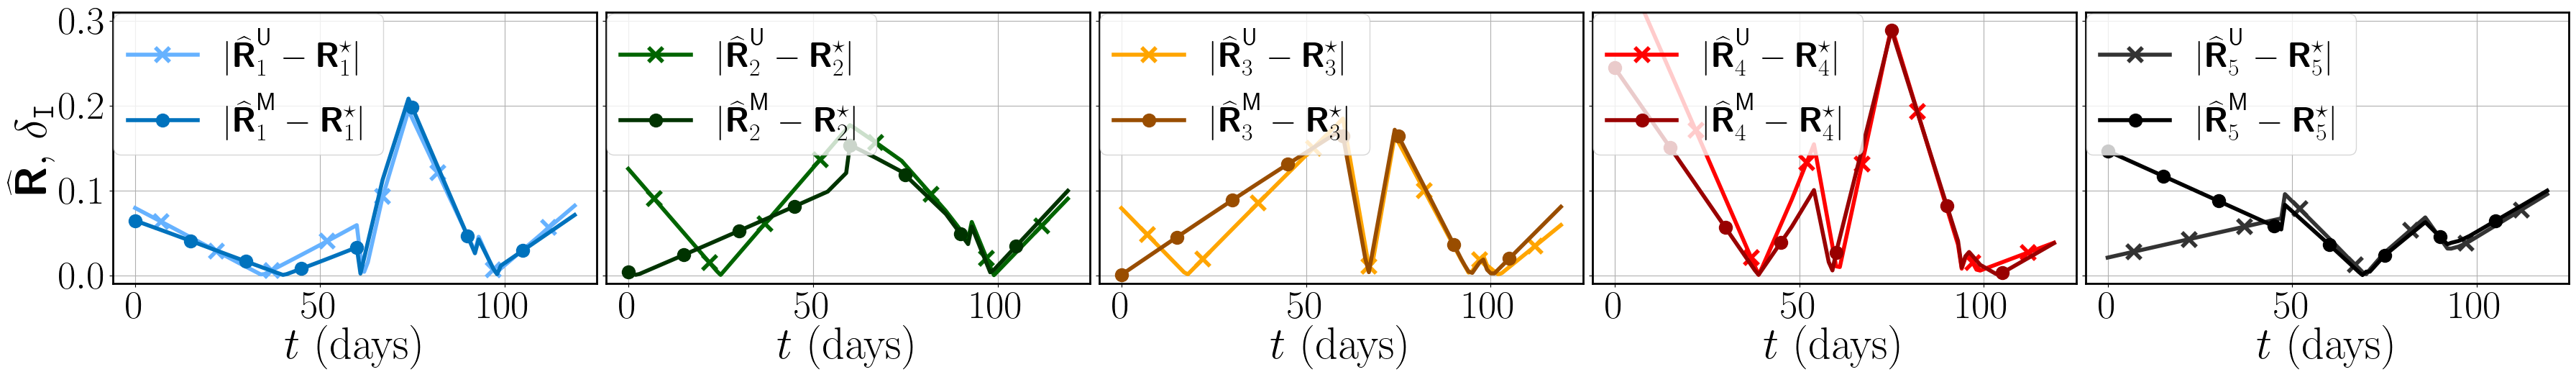

In [6]:
display_comparison_uni_multi(connectStruct, configMulti, R_spat_corr, R_uni, R_multi)
display_comparison_error_uni_multi(connectStruct, configMulti, R_spat_corr, R_uni, R_multi)